# Grade Regression Using Transformer Model

## Creating the Datasets

### Loading and cleaning the data

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

seed=42

os.chdir('/home/jovyan/shared/2020_06_10_bad_reviewer')

In [ ]:
reviewer_df = pd.read_csv('results/reviewer_agg_stats.csv', index_col=[0])
cleared_submissions = pd.read_csv('bin/cleared_submissions.csv')
submissions_df = pd.read_csv('bin/submissions_df.csv', index_col=[0])
reviews_df = pd.read_csv('bin/reviews_df.csv', index_col = [0])

# Rename the columns to disambiguate whether the id represents a reviewer or an author
submissions_df = submissions_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_author'})
reviewer_df = reviewer_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_reviewer'})
reviews_df = reviews_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_reviewer'})
cleared_submissions = cleared_submissions.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_author'})

# Get the author id into reviews_df
reviews_df = pd.merge(reviews_df, cleared_submissions[['peer_submission_id', 'uva_peer_assignments_user_id_author']], on='peer_submission_id', how="left")
# Note that authors could only be found for 864,073 out of the 1,059,044 reviews.
reviews_df.count()

peer_review_id                                             1084657
uva_peer_assignments_user_id_reviewer                      1084657
peer_review_created_ts                                     1084657
peer_submission_id                                         1084657
peer_assignment_review_schema_part_prompt_score             929706
peer_assignment_review_schema_part_option_score             929706
peer_assignment_review_schema_part_prompt_free_response    1084640
peer_review_part_free_response_text                        1059044
uva_peer_assignments_user_id_author                         864073
dtype: int64

In [3]:
# Find duplicate essays
print(len(submissions_df))
submissions_df['is_duplicate'] = submissions_df.duplicated(subset=['text'], keep=False)
texts = submissions_df[submissions_df['is_duplicate']==False][['uva_peer_assignments_user_id_author', 'text']]

27909


In [4]:
# Get rid of duplicate reviews
reviews_df.drop(list(range(755643, 755650)), axis=0, inplace=True)
reviews_df.drop(list(range(1025262, 1025269)), axis=0, inplace=True)

In [5]:
# Get number of words for the labelled texts
texts['num_words'] = texts.apply(lambda row: len(row['text'].split()), axis=1)

# Get reviewer variance
reviewer_df['total_variance'] = reviewer_df['total_sd']**2

In [6]:
### Include All Reviewers
labelled_data = texts.merge(reviews_df, on='uva_peer_assignments_user_id_author', how='left')
essay_scores = (labelled_data
                .groupby(['uva_peer_assignments_user_id_reviewer',
                          'peer_submission_id',
                          'uva_peer_assignments_user_id_author'])
                .agg({'peer_assignment_review_schema_part_option_score':'sum'})
                .reset_index()
               )

### Create Ten Dataframes

In [7]:
criteria = {
    'baseline': {},
    'variance_0': {'var': 0.0},
    'variance_1': {'var': 1.0},
    'variance_2_5': {'var': 2.5},
    'ttr_0_0_5': {'ttr': 0.05},
    'ttr_0_2': {'ttr': 0.2},
    'ttr_0_4': {'ttr': 0.4},
    'variance_0_ttr_0_0_5': {'var': 0.0, 'ttr': 0.05},
    'variance_0_ttr_0_4': {'var': 0.0, 'ttr': 0.4},
    'variance_2_5_ttr_0_4': {'var': 2.5, 'ttr': 0.4},
}

def df_from_criteria(reviewer_df, essay_scores, criteria):
    '''
    reviewer_df: contains reviewer id, submission ids, ttr, and variance 
    essay_scores: author id, reviewer id, submission id, and the sum score for each review
    ttr_filter: True for all rows unles TTR criterion is set
    var_filter: True for all rows unless Variance criterion is set
    '''
    
    if 'var' in criteria and 'ttr' in criteria:
        reviewer_df = reviewer_df[(reviewer_df['total_variance'] > criteria['var']) | (reviewer_df['total_ttr'] >= criteria['ttr'])]
    elif 'var' in criteria:
        reviewer_df = reviewer_df[reviewer_df['total_variance'] > criteria['var']]
    elif 'ttr' in criteria:
        reviewer_df = reviewer_df[reviewer_df['total_ttr'] >= criteria['ttr']]

    essay_scores = (reviewer_df
                    .merge(essay_scores,
                           on='uva_peer_assignments_user_id_reviewer', 
                           how='left')
                   )
    
    essay_scores_final = (
        essay_scores[
            essay_scores
            .groupby('peer_submission_id')['peer_submission_id']
            .transform('size') >= 2
        ]
        .groupby([
            'peer_submission_id',
            'uva_peer_assignments_user_id_author'
        ])
        .agg({
            'peer_assignment_review_schema_part_option_score':'mean'
        })
        .reset_index()
    )
    
    return (
        essay_scores_final
        .merge(texts, on='uva_peer_assignments_user_id_author')[[
            'text',
            'peer_assignment_review_schema_part_option_score',
        ]]
        .rename(columns={'peer_assignment_review_schema_part_option_score':'labels'})
    )

In [8]:
datadicts = {}
for k, v in criteria.items():
    print(k.ljust(20), end=': ')
    datadicts[k] = df_from_criteria(reviewer_df, essay_scores, v)
    print(f'{datadicts[k].shape[0]:>6,}')

baseline            : 22,871
variance_0          : 19,336
variance_1          : 12,574
variance_2_5        :  8,766
ttr_0_0_5           : 21,168
ttr_0_2             : 16,950
ttr_0_4             : 11,319
variance_0_ttr_0_0_5: 22,244
variance_0_ttr_0_4  : 20,209
variance_2_5_ttr_0_4: 16,116


           num_words    labels
num_words   1.000000  0.164521
labels      0.164521  1.000000


Text(0.5, 1.0, 'Correlation between Essay Score and Number of Words')

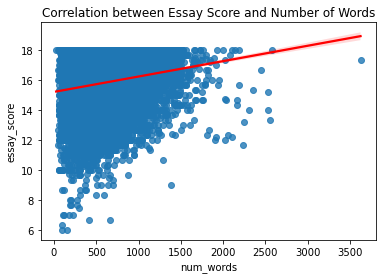

In [9]:
datadicts['baseline']['num_words'] = datadicts['baseline'].apply(lambda row: len(row['text'].split()), axis=1)
print(datadicts['baseline'][['num_words', 'labels']].corr())

sns.regplot(data=datadicts['baseline'], x='num_words', y='labels', line_kws={"color": "red"})
plt.ylabel('essay_score')
plt.title('Correlation between Essay Score and Number of Words')
#baseline[['num_words', 'labels']].plot.scatter('num_words', 'labels')

## Build the HuggingFace Models
### Load the packages

In [10]:
#datasets installed in default jupyter image now. no need to pip install
import numpy as np
import pandas as pd

from datasets import load_dataset, load_metric, Dataset, Value, ClassLabel, Features, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,
                          EarlyStoppingCallback, DataCollatorWithPadding)

### Build the Datasets

In [11]:
def buildDataset(df):
    full_dataset = Dataset.from_pandas(df, preserve_index=False)
    # 70% train, 30% test + validation
    train_testvalid = full_dataset.train_test_split(test_size=0.3, seed=seed)
    # Split the 30% test + valid in half test, half valid
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
    # gather everyone if you want to have a single DatasetDict
    final_dataset = DatasetDict({
        'train': train_testvalid['train'],
        'test': test_valid['test'],
        'valid': test_valid['train']})
    return final_dataset

#### Rock and roll

In [12]:
datasets = {k: buildDataset(v) for k, v in datadicts.items()}

#### Check it out

In [13]:
# Check them one by one
print(datasets['baseline'])

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'num_words'],
        num_rows: 16009
    })
    test: Dataset({
        features: ['text', 'labels', 'num_words'],
        num_rows: 3431
    })
    valid: Dataset({
        features: ['text', 'labels', 'num_words'],
        num_rows: 3431
    })
})


### Instantiate the tokenizer and model

In [48]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

def model_init():
    return AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                              num_labels=1).to("cuda")

### Tokenize the text

In [15]:
def tokenize_inputs(example):
    return tokenizer(example['text'], truncation=True)

# groups together inputs of similar length for efficiency
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
%%capture

datasets = {k: dataset.map(tokenize_inputs, batched=True)
            for k, dataset in datasets.items()}

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [24]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Build the Models

### Function to Compute Metrics

In [49]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr 

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

## Now for the Main Event...

### Train the Models

We handle finetuning and inference inside a function call at the same time.  
We save the results as numpy arrays in memory, and we also save the finetuned models to disk at each checkpoint.  
Only one model in GPU memory at a time.

In [112]:
def train_model(dataset_name, dataset):
    training_args = TrainingArguments(
        output_dir = f'./results/{dataset_name}_checkpoints',
        optim = 'adamw_torch',
        num_train_epochs = .1, ########################### DEBUGGING ###############################
        per_device_train_batch_size = 64,
        per_device_eval_batch_size = 64,
        weight_decay = 0.01,
        learning_rate = 2e-5,
        logging_dir = f'./logs/{dataset_name}',
        save_total_limit = 10,
        load_best_model_at_end = True,
        metric_for_best_model = 'rmse',
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        greater_is_better = False,
        seed=seed,
        log_level = 'error', # took me ages to find these options
        disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
    ) 

    # Call the Trainer
    trainer = Trainer(
        model_init = model_init,
        args = training_args,
        data_collator=data_collator,
        train_dataset = dataset['train'],
        eval_dataset = dataset['valid'],
        compute_metrics = compute_metrics_for_regression,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    trainer.train()

    # Get predictions, labels
    return trainer.predict(dataset['test'])

In [ ]:
model_metrics = {}
model_results = {}
for model_name, dataset in datasets.items():
    preds, labs, metrics = train_model(model_name, dataset)
    preds = preds.flatten()
    model_results[model_name] = {'predicted': preds, 'true': labs}
    model_metrics[model_name] = metrics

Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
0,No log,168.351410,168.351410,12.975030,12.873399,-62.738506,466943.776159


baseline            : r=0.0527, p=0.002


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
0,No log,164.251419,164.251419,12.816061,12.692967,-50.114090,410038.068966


variance_0          : r=0.19, p=4.19e-25


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
0,No log,183.137909,183.137909,13.532845,13.372551,-40.639119,303089.781548


variance_1          : r=0.265, p=1.15e-31


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
0,No log,193.809341,193.809357,13.921543,13.725161,-34.164743,229435.376426


variance_2_5        : r=0.291, p=4.68e-27


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
0,No log,170.483704,170.483704,13.056941,12.937064,-53.310562,442780.784882


ttr_0_0_5           : r=0.121, p=6.93e-12


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
0,No log,176.896698,176.896698,13.300252,13.171571,-50.247578,376016.944138


ttr_0_2             : r=0.168, p=1.81e-17


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
0,No log,198.419098,198.419098,14.086131,13.964996,-56.446565,281444.409894


ttr_0_4             : r=0.201, p=5.92e-17


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
0,No log,167.573013,167.573013,12.945000,12.835720,-57.573470,458393.047648


variance_0_ttr_0_0_5: r=0.13, p=5.75e-14


Epoch,Training Loss,Validation Loss


In [140]:
for model_name, res in model_results.items():
    preds, labs = res['predicted'], res['true']
    print('{}: r~{:.3f}, p~{:.3f}'.format(model_name.ljust(20), *pearsonr(preds, labs)))

baseline            : r~0.053, p~0.002
variance_0          : r~0.190, p~0.000
variance_1          : r~0.265, p~0.000
variance_2_5        : r~0.291, p~0.000
ttr_0_0_5           : r~0.121, p~0.000
ttr_0_2             : r~0.168, p~0.000
ttr_0_4             : r~0.201, p~0.000
variance_0_ttr_0_0_5: r~0.130, p~0.000
variance_0_ttr_0_4  : r~0.173, p~0.000
variance_2_5_ttr_0_4: r~0.181, p~0.000


## Analysis of the Models

In [141]:
pd.DataFrame.from_dict(model_metrics, orient='index')

,test_loss,test_mse,test_rmse,test_mae,test_r2,test_smape,test_runtime,test_samples_per_second,test_steps_per_second
baseline,168.785278,168.785278,12.991739,12.890633,-63.357636,467072.484990,14.0261,244.615,3.850
variance_0,164.011520,164.011520,12.806698,12.679286,-48.502300,409948.216477,12.0878,239.994,3.805
variance_1,182.322571,182.322571,13.502687,13.352719,-43.142992,303385.640700,7.9195,238.274,3.788
variance_2_5,196.071762,196.071762,14.002563,13.815821,-36.132356,229692.276806,5.5196,238.242,3.805
ttr_0_0_5,169.577728,169.577713,13.022201,12.898135,-51.107054,442496.644836,13.3926,237.146,3.733
ttr_0_2,175.661774,175.661758,13.253745,13.116300,-46.788707,375691.878883,10.7430,236.713,3.723
ttr_0_4,197.194427,197.194427,14.042593,13.923558,-57.347176,281203.279152,7.1752,236.650,3.763
variance_0_ttr_0_0_5,166.898743,166.898743,12.918930,12.810462,-57.966716,458137.814804,14.1292,236.177,3.751
variance_0_ttr_0_4,165.219589,165.219589,12.853777,12.735514,-52.486147,424479.451187,12.8269,236.379,3.742
variance_2_5_ttr_0_4,175.993790,175.993790,13.266265,13.132139,-47.978411,362615.080232,10.2214,236.562,3.718


### Graph the Predicted and Actual Scores for Each Model

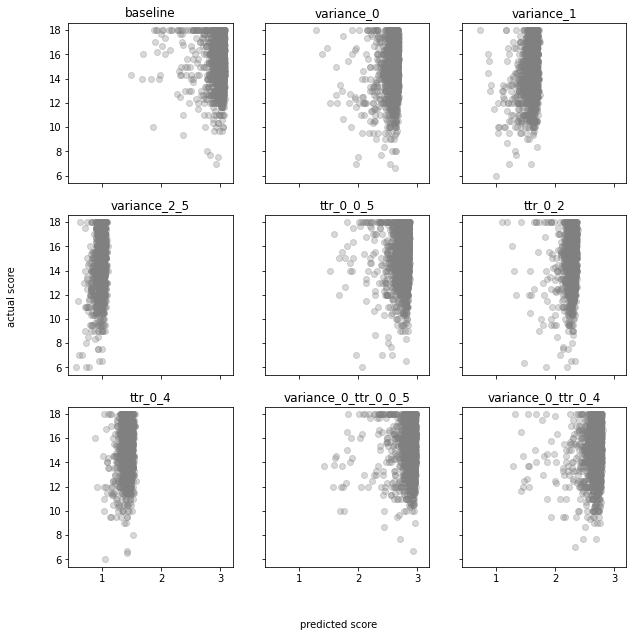

In [142]:
from matplotlib import pyplot as plt


fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
for (model_name, results), ax in zip(model_results.items(), axs.flatten()): # axs.flatten() is a useful matplotlib trick for plt.subplots()
    ax.scatter(results['predicted'], results['true'], color='gray', alpha=0.3)
    ax.set_title(model_name)
    
# plt.xlim([5.5, 18.25])
# plt.xticks(np.arange(6, 19, step=2)) 
fig.text(0.5, 0.04, 'predicted score', ha='center')
fig.text(0.04, 0.5, 'actual score', va='center', rotation='vertical')
fig.show()

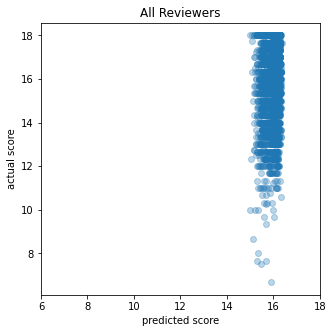

In [52]:
plt.figure(figsize=(5,5))
plt.scatter(baseline_predictions, baseline_labels, alpha=0.3)
plt.title('All Reviewers')
plt.xlabel('predicted score')
plt.ylabel('actual score')
plt.xlim([14, 18])
plt.xticks(np.arange(6, 19, step=2)) 
plt.show()

## GPU memory diagnostics

In [111]:
import torch
# import gc
# torch.cuda.empty_cache()
# gc.collect()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |   33448 MB |   51999 GB |   51999 GB |
|       from large pool |       0 B  |   33428 MB |   51943 GB |   51943 GB |
|       from small pool |       0 B  |      21 MB |      55 GB |      55 GB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |   33448 MB |   51999 GB |   51999 GB |
|       from large pool |       0 B  |   33428 MB |   51943 GB |